# Leves Fast | Comparação dos scores dos birôs

maio de 2022 | Felipe Oliveira e Lucas Lima

------------

O objetivo desse notebook é comparar a performance dos scores dos birôs: vigentes x novos.

| Birô | Vigente | Novo |
|------|---------|------|
| BVS  | P3      | P4   |
| Quod | QuodScore | QuodScore 3ª geração |

# Pacotes

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from pyspark.sql.functions import *
from pyspark.sql.functions import expr
from pyspark.sql.types import ByteType,ShortType,LongType,IntegerType,DoubleType
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
import statsmodels.api as sm

# Classes

In [0]:
%run /Users/felipe.espirito@bv.com.br/Modulos

# Funções

In [0]:
%run /Users/lucas.lima@bv.com.br/funcoes/funcoes_lucas

tabela_mmNtx(nomebase,nvar,nfxvar,ntarget) | última atualização: 16/03/2022

calc_perf(n_base,v_score,v_target) | última atualização: 03/03/2022

[1] "calcKS_R <- function(n_target,n_score)"

cria_fxs(nbase1,nbase2,nvar,n_fxs,nova_var) | última atualização 08/03/2022

calc_IV(nbase1,nvar_fx,ntarget) | última atualização 11/03/2022

aplicaRUPD(nbase,nvar) | Última atualização: 30/03/2022

encontra_modelo(X, y, classificador, n_divisoes, n_repeticoes,hiperparams = None, scoring="accuracy", random_state=1109) 
 Última atualização: 21/03/2022

# Dados

In [0]:
%sql
select * from cred_lucaslima.bvs_renda_score limit 3

NuProposta,NuCpfCnpj,DtEntradaProposta,elegiveis,anomes,inad30,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1
531975096,1255126,19/08/2021,1.0,202108,0,663.0,12150.0
531977847,1726188,30/08/2021,1.0,202108,1,370.0,3550.0
391801210,2609169,23/08/2021,1.0,202108,0,542.0,12000.0


In [0]:
%sql
select count(1) as N from cred_lucaslima.bvs_renda_score

N
295299


In [0]:
base_bvs=spark.sql('''
  select * from cred_lucaslima.bvs_renda_score
''')


base_ncli=spark.sql('''
  select * from cred_lucaslima.levesfast_escorada_ncli
''')
cond=[base_ncli.NuProposta==base_bvs.NuProposta]
base_ncli2=base_ncli.join(base_bvs,cond,how='left')\
      .select(base_ncli['*'],
              base_bvs.scrcrdpnmveipfctbclfv2,
              base_bvs.rndrprpnmpfmmlregv1)
base_ncli_pd=base_ncli2.toPandas()


base_cli=spark.sql('''
  select * from cred_lucaslima.levesfast_escorada_cli
''')
cond=[base_cli.NuProposta==base_bvs.NuProposta]
base_cli2=base_cli.join(base_bvs,cond,how='left')\
      .select(base_cli['*'],
              base_bvs.scrcrdpnmveipfctbclfv2,
              base_bvs.rndrprpnmpfmmlregv1)
base_cli_pd=base_cli2.toPandas()

In [0]:
base_total=base_ncli_pd.append(base_cli_pd)

In [0]:
print(len(base_ncli_pd),len(base_cli_pd),len(base_total),sep='\n')

150969
144330
295299

In [0]:
base_cli_pd=base_cli_pd.fillna(-99999999)

# Análises

## Comparações Score veículo e renda

In [0]:
lista_scores=['P3_ult_ret','P4_BVS','scrcrdpnmveipfctbclfv2','rndrprpnmpfmmlregv1',
              'SCORE_HSPN','SCORE_HVLD',
              'QuodScore', 'QuodScore_v2','Blend_Novo_1_1_arred']
lista_safras=[202108,202109,202110,202111,202112]

for nscore in lista_scores:
  base_total=cria_fxs(base_total[base_total.Safra_main<=202110],base_total,nscore,10,'qs'+nscore)
  base_ncli_pd=cria_fxs(base_ncli_pd[base_ncli_pd.Safra_main<=202110],base_ncli_pd,nscore,10,'qs'+nscore)
  base_cli_pd=cria_fxs(base_cli_pd[base_cli_pd.Safra_main<=202110],base_cli_pd,nscore,10,'qs'+nscore)
  
def tabela_qs(nbase):
  tabfxs1=pd.crosstab(nbase['qs'+'P3_ult_ret'],columns='P3_ult_ret',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs12=pd.crosstab(nbase['qs'+'P4_BVS'],columns='P4_BVS',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs13=pd.crosstab(nbase['qs'+'scrcrdpnmveipfctbclfv2'],columns='scrcrdpnmveipfctbclfv2',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs2=pd.crosstab(nbase['qs'+'rndrprpnmpfmmlregv1'],columns='rndrprpnmpfmmlregv1',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs3=pd.crosstab(nbase['qs'+'SCORE_HSPN'],columns='SCORE_HSPN',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs4=pd.crosstab(nbase['qs'+'SCORE_HVLD'],columns='SCORE_HVLD',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs5=pd.crosstab(nbase['qs'+'QuodScore'],columns='QuodScore',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs6=pd.crosstab(nbase['qs'+'QuodScore_v2'],columns='QuodScore_v2',
             values=nbase.inad30,aggfunc=np.mean)
  tabfxs7=pd.crosstab(nbase['qs'+'Blend_Novo_1_1_arred'],columns='Blend_Novo_1_1_arred',
             values=nbase.inad30,aggfunc=np.mean)
  tab_qs=tabfxs1.join(tabfxs12,rsuffix='r').join(tabfxs13,rsuffix='r')\
    .join(tabfxs2,rsuffix='r').join(tabfxs3,rsuffix='r').join(tabfxs4,rsuffix='r')\
    .join(tabfxs5,rsuffix='r').join(tabfxs6,rsuffix='r').join(tabfxs7,rsuffix='r')
  
  return tab_qs

In [0]:
vars_WoE_cli = list(base_cli_pd.filter(like='WoE').columns)
vars_WoE_ncli = list(base_ncli_pd.filter(like='WoE').columns)
novas = ['scrcrdpnmveipfctbclfv2', 'rndrprpnmpfmmlregv1']

X_list_cli = vars_WoE_cli+['P3_ult_ret','P4_BVS','SCORE_HSPN','QuodScore_v2','QuodScore', *novas]
X_list_ncli = vars_WoE_ncli+['P3_ult_ret','P4_BVS','SCORE_HSPN','QuodScore_v2','QuodScore', *novas]
X_list3 = X_list_ncli + ['Blend_Novo_1_1_arred']

X1_cli = base_cli_pd[X_list_cli]
X3_ncli = base_ncli_pd[X_list3]
y_cli = base_cli_pd.inad30
y_ncli = base_ncli_pd.inad30

target = 'inad30'
modelo_logistica = "yhat_blend"
modelos = []

vis_cli = Visualizador(base=base_cli_pd)
vis_ncli = Visualizador(base=base_ncli_pd)

### KS por safra

In [0]:
tabela1_KS=KS_por_safra(base_total, lista_scores)
tabela1_KS

modelo,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
Safra,,,,,,,,,
202108,18.5795,22.2102,26.4554,12.2034,21.1501,20.1139,16.5972,21.2477,22.5679
202109,19.5343,23.4136,27.3098,14.7255,23.4320,21.8210,15.8684,21.4173,22.3027
202110,16.9736,22.8587,26.0764,13.6429,20.9619,20.9464,16.3461,21.9015,22.4393
202111,16.5311,20.2176,25.1373,13.2389,22.3363,21.2622,15.4614,20.6254,24.9955
202112,15.1841,16.2378,22.0492,10.2090,18.0376,16.8908,0.7299,16.7688,19.9498


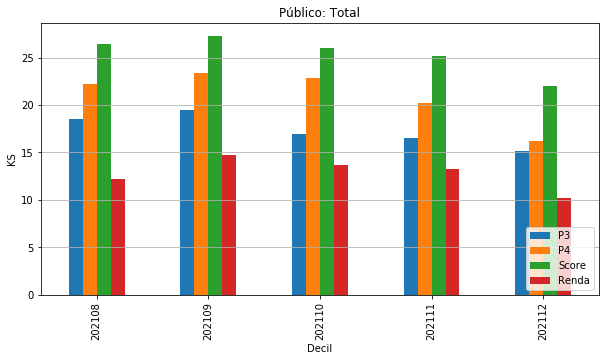

In [0]:
tabela1_KS[['P3_ult_ret','P4_BVS','scrcrdpnmveipfctbclfv2','rndrprpnmpfmmlregv1']]\
  .plot.bar(figsize=(10,5),title='Público: Total')

plt.ylabel('KS')
plt.xlabel('Decil')
plt.grid(True,axis='y')
plt.legend(['P3','P4','Score','Renda'],loc='lower right',)

In [0]:
tabela2_KS=KS_por_safra(base_ncli_pd, lista_scores)
tabela2_KS

modelo,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
Safra,,,,,,,,,
202108,17.7546,20.2280,24.1503,12.2531,20.0644,16.9749,16.1027,18.2180,16.4022
202109,18.5327,21.7427,25.8459,15.8918,21.5356,18.9365,15.9145,20.0108,16.6297
202110,15.0798,21.1807,25.0420,11.7221,19.1208,17.5648,17.1182,20.3182,17.2721
202111,14.9951,21.2514,24.6287,13.3238,21.2569,17.5713,17.6625,17.1391,19.3539
202112,13.4107,14.6073,20.2736,11.1708,17.1131,15.7267,1.1893,15.1148,15.6414


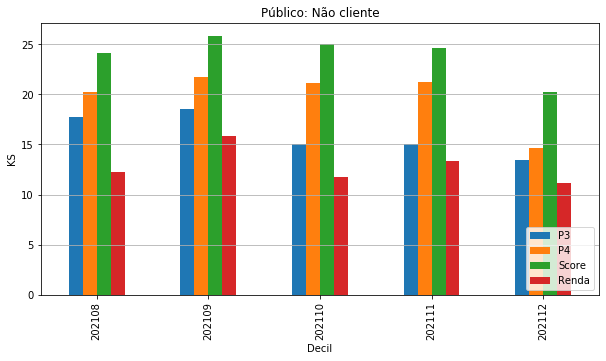

In [0]:
tabela2_KS[['P3_ult_ret','P4_BVS','scrcrdpnmveipfctbclfv2','rndrprpnmpfmmlregv1']]\
  .plot.bar(figsize=(10,5),title='Público: Não cliente')

plt.ylabel('KS')
plt.xlabel('Decil')
plt.grid(True,axis='y')
plt.legend(['P3','P4','Score','Renda'],loc='lower right',)

In [0]:
tabela3_KS=KS_por_safra(base_cli_pd, lista_scores)
tabela3_KS

modelo,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
Safra,,,,,,,,,
202108,19.5539,25.9946,30.0378,11.1733,22.3962,25.0517,18.2789,24.0504,30.6511
202109,21.6352,25.7289,29.7105,10.8213,27.6280,24.3935,17.0133,22.5302,27.2525
202110,18.9230,26.3849,27.3290,16.0306,23.2483,25.5383,16.6353,22.5623,29.4059
202111,19.8337,20.6358,28.8531,14.4434,25.0481,25.3209,16.3267,24.9001,30.2928
202112,18.5569,19.2527,24.6163,7.9178,19.8172,18.8828,0.5697,20.3842,24.6514


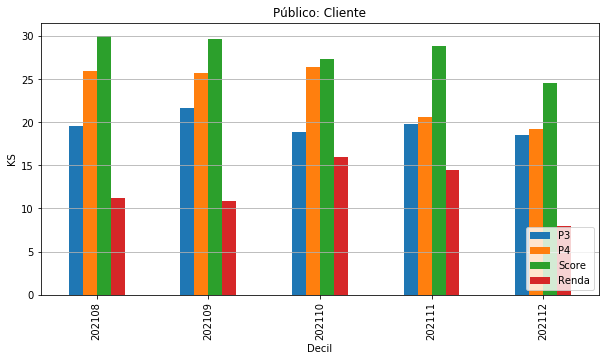

In [0]:
tabela3_KS[['P3_ult_ret','P4_BVS','scrcrdpnmveipfctbclfv2','rndrprpnmpfmmlregv1']]\
  .plot.bar(figsize=(10,5),title='Público: Cliente')

plt.ylabel('KS')
plt.xlabel('Decil')
plt.grid(True,axis='y')
plt.legend(['P3','P4','Score','Renda'],loc='lower right',)

### Ordenação inad

In [0]:
tabela1_inad=tabela_qs(base_total[base_total.Safra_main<=202110])*100
tabela1_inad

col_0,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
qsP3_ult_ret,,,,,,,,,
0,5.380048,6.157824,7.180334,4.989488,6.227643,5.692353,5.590874,5.786097,5.907098
1,4.087353,4.497354,4.633112,3.511329,3.985870,4.132280,3.751101,4.252384,4.331560
2,3.519741,3.426276,3.564356,2.992802,3.558378,3.536289,3.128384,3.584187,3.736780
3,3.057653,2.960103,2.835425,2.859337,3.109174,3.170252,2.755540,3.254593,3.160766
4,2.719577,2.831586,2.647572,2.517499,2.742871,2.930773,3.046671,2.575388,2.774138
5,2.578508,2.136830,1.958702,2.724241,2.201782,2.411364,2.543491,2.221951,2.485371
6,1.995145,2.000942,1.760606,2.183609,1.957634,1.868761,1.977807,2.074249,2.078738
7,1.848926,1.680521,1.394774,2.184227,1.769364,1.733549,1.985505,1.541890,1.409918
8,1.525227,1.264836,1.147022,1.856331,1.367562,1.255683,1.656278,1.494300,1.129314


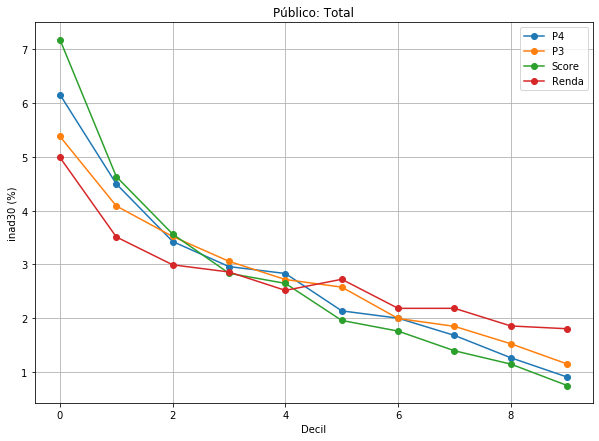

In [0]:
tabela1_inad['P4_BVS'].plot.line(marker='o',label='P4',figsize=(10,7))
tabela1_inad['P3_ult_ret'].plot.line(marker='o',label='P3',figsize=(10,7))
tabela1_inad['scrcrdpnmveipfctbclfv2'].plot.line(marker='o',label='Score',figsize=(10,7))
tabela1_inad['rndrprpnmpfmmlregv1'].plot.line(marker='o',label='Renda',figsize=(10,7),
                                             title='Público: Total')

plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

In [0]:
tabela2_inad=tabela_qs(base_ncli_pd[base_ncli_pd.Safra_main<=202110])*100
tabela2_inad

col_0,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
qsP3_ult_ret,,,,,,,,,
0,5.767572,6.692658,7.496479,5.971781,6.986568,6.104714,6.086101,6.430659,5.883640
1,4.273036,5.053134,5.211513,3.878829,4.532180,4.435614,4.388646,4.456251,4.321456
2,4.188315,3.632312,4.180961,3.461022,3.918394,3.815546,3.611201,3.865473,3.716361
3,3.752220,3.484358,3.594845,3.000333,3.481326,3.692572,3.195710,3.846154,3.886039
4,3.004715,3.481925,3.052859,3.067693,3.130511,3.272686,3.700890,3.160757,3.259438
5,3.190653,2.679048,2.463816,2.795133,2.736678,3.059717,2.858999,2.740474,2.994198
6,2.468094,2.383617,2.282113,2.562270,2.112313,2.427452,2.338047,2.593035,2.546093
7,2.043536,2.107754,1.593496,2.602301,2.213096,2.110212,2.119292,1.868036,2.512269
8,1.996431,1.478702,1.324796,2.374223,1.825127,1.825149,1.924140,1.727885,1.662936


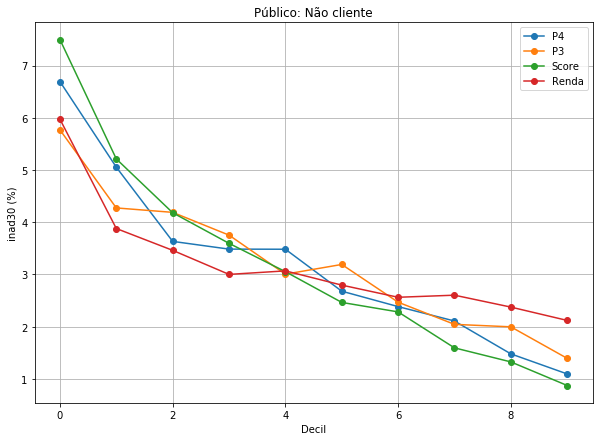

In [0]:
tabela2_inad['P4_BVS'].plot.line(marker='o',label='P4',figsize=(10,7))
tabela2_inad['P3_ult_ret'].plot.line(marker='o',label='P3',figsize=(10,7))
tabela2_inad['scrcrdpnmveipfctbclfv2'].plot.line(marker='o',label='Score',figsize=(10,7))
tabela2_inad['rndrprpnmpfmmlregv1'].plot.line(marker='o',label='Renda',figsize=(10,7),
                                             title='Público: Não cliente')

plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

In [0]:
tabela3_inad=tabela_qs(base_cli_pd[base_cli_pd.Safra_main<=202110])*100
tabela3_inad

col_0,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
qsP3_ult_ret,,,,,,,,,
0,4.814288,5.501159,6.486626,3.524550,5.261800,5.189048,4.511082,4.803437,6.260510
1,3.528043,3.612266,3.910758,2.845738,3.367092,3.642427,3.366005,3.738318,3.831954
2,2.788080,3.317163,2.761136,2.503182,3.159111,2.878748,2.673037,2.990847,2.658885
3,2.270074,2.319182,2.085778,2.481358,2.593374,2.556564,2.186361,2.520787,2.715379
4,2.179050,2.044025,1.973257,2.473132,2.083052,2.483985,2.330122,2.115637,2.181097
5,1.914324,1.536458,1.400052,1.945245,1.672060,1.721382,2.299615,1.936919,1.635677
6,1.699569,1.593372,1.478353,1.993723,1.541933,1.410493,1.659377,1.592027,1.205445
7,1.596366,1.185146,1.085661,1.674890,1.343166,1.305247,1.617532,1.144683,0.915015
8,1.092537,0.928105,0.914554,1.747700,1.148658,0.952160,1.196670,1.213149,0.643345


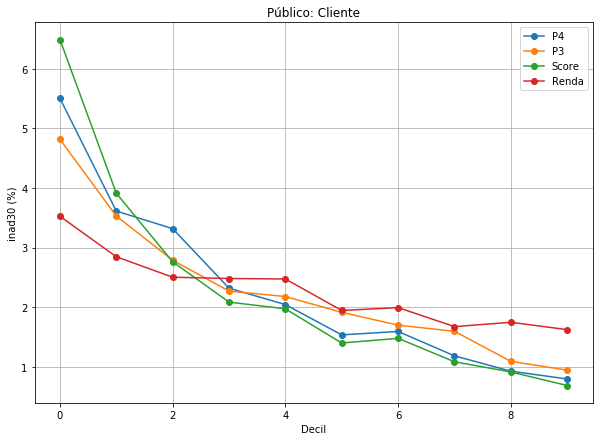

In [0]:
tabela3_inad['P4_BVS'].plot.line(marker='o',label='P4',figsize=(10,7))
tabela3_inad['P3_ult_ret'].plot.line(marker='o',label='P3',figsize=(10,7))
tabela3_inad['scrcrdpnmveipfctbclfv2'].plot.line(marker='o',label='Score',figsize=(10,7))
tabela3_inad['rndrprpnmpfmmlregv1'].plot.line(marker='o',label='Renda',figsize=(10,7),
                                             title='Público: Cliente')

plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

## Clientes

###Avaliação Modelo 1.4 + Novas BVS

In [0]:
"""Considerações Remi: criar um modelo para cada um dos escopos: 
1.score veículos + renda
2.score veículo
3. renda
"""

X=X1_cli
y=y_cli

selected_features_BE=[
 'WoE_PF_CP_VOL04_PF_C',
 'WoE_Int_Internas1',
 'WoE_score_ajust',
 'P4_BVS',
 'SCORE_HSPN',
 'QuodScore_v2',
 *novas
]

#### Escopo score veículos + renda

In [0]:
X_1 = sm.add_constant(X.loc[:,selected_features_BE])
model = sm.Logit(y,X_1).fit()
X_aplic=['const']+selected_features_BE
	
base_cli_pd['const']=1
base_cli_pd['yhat_novas'] = model.predict(base_cli_pd[X_aplic])
base_cli_pd['yhat1_4_novas']=(1-base_cli_pd['yhat_novas'])*1000
base_cli_pd['yhat1_4c_novas']=600-(20/np.log(2))*np.log((1-base_cli_pd['yhat_novas'])/(1-(1-base_cli_pd['yhat_novas'])))

modelos.append("yhat1_4_novas")
print(model.summary())

print('KS desenv: ', calc_perf(base_cli_pd,'yhat_novas','inad30') )

Optimization terminated successfully.
 Current function value: 0.082983
 Iterations 11
 Logit Regression Results 
==============================================================================
Dep. Variable: inad30 No. Observations: 144330
Model: Logit Df Residuals: 144321
Method: MLE Df Model: 8
Date: Wed, 11 May 2022 Pseudo R-squ.: 0.1029
Time: 18:16:09 Log-Likelihood: -11977.
converged: True LL-Null: -13350.
Covariance Type: nonrobust LLR p-value: 0.000
==========================================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
const 0.0352 0.142 0.247 0.805 -0.244 0.314
WoE_PF_CP_VOL04_PF_C -0.3498 0.073 -4.817 0.000 -0.492 -0.207
WoE_Int_Internas1 -0.7721 0.039 -20.050 0.000 -0.848 -0.697
WoE_score_ajust -0.4975 0.071 -6.991 0.000 -0.637 -0.358
P4_BVS -1.52e-08 4.2e-09 -3.617 0.000 -2.34e-08 -6.96e-09
SCORE_HSPN 4.173e-08 3.79e-09 11.021 0.000 3.43e-08 4.91e-08
QuodScore_v2 -0.0011 0.000 -6.421 0.000 -0.001 -0.001
scrcrdpnmveipfctbclfv2 -0.0052 0.000 -23.748 0.000 -0.006 -0.005
rndrprpnmpfmmlregv1 -7.2e-06 3.3e-06 -2.183 0.029 -1.37e-05 -7.37e-07
==========================================================================================
KS desenv: (40.34127732623877, 144330, 1.8589343864754384, 141647, 2683)

In [0]:
lnvar=[]
lbeta=[]
lbetasd=[]

i=0
for nvar in model.params.index[1:len(model.params.index)]:
  i=i+1
  importance=np.abs(model.params[i]*np.std(X[nvar])/np.std(y))
  lnvar=lnvar+[nvar]
  lbeta=lbeta+[model.params[i]]
  lbetasd=lbetasd+[importance]

tab_importance=pd.DataFrame(
  {
    'var': lnvar,
    'Coef': lbeta,
    'Coef_sd':np.round(lbetasd,4)
  }
)
tab_importance['p_imp']=np.round(tab_importance['Coef_sd']*100/tab_importance['Coef_sd'].sum(),3)
tab_importance.sort_values('Coef_sd',ascending=False)

,var,Coef,Coef_sd,p_imp
4,SCORE_HSPN,4.172575e-08,11.3295,54.335
6,scrcrdpnmveipfctbclfv2,-5.226492e-03,3.6333,17.425
1,WoE_Int_Internas1,-7.721380e-01,2.4929,11.956
2,WoE_score_ajust,-4.975162e-01,1.0467,5.020
5,QuodScore_v2,-1.068255e-03,0.9087,4.358
0,WoE_PF_CP_VOL04_PF_C,-3.498458e-01,0.7738,3.711
7,rndrprpnmpfmmlregv1,-7.200228e-06,0.4063,1.949
3,P4_BVS,-1.520304e-08,0.2599,1.246


#### Escopo veículos

In [0]:
features_escopo = selected_features_BE.copy()
features_escopo.remove("rndrprpnmpfmmlregv1")

X_1 = sm.add_constant(X.loc[:,features_escopo])
model = sm.Logit(y,X_1).fit()
X_aplic=['const']+features_escopo
	
base_cli_pd['const']=1
base_cli_pd['yhat_veic'] = model.predict(base_cli_pd[X_aplic])
base_cli_pd['yhat1_4_veic']=(1-base_cli_pd['yhat_veic'])*1000
base_cli_pd['yhat1_4c_veic']=600-(20/np.log(2))*np.log((1-base_cli_pd['yhat_veic'])/(1-(1-base_cli_pd['yhat_veic'])))

modelos.append("yhat1_4_veic")
print(model.summary())

print('KS desenv: ', calc_perf(base_cli_pd,'yhat1_4_veic','inad30') )

Optimization terminated successfully.
 Current function value: 0.083000
 Iterations 11
 Logit Regression Results 
==============================================================================
Dep. Variable: inad30 No. Observations: 144330
Model: Logit Df Residuals: 144322
Method: MLE Df Model: 7
Date: Wed, 11 May 2022 Pseudo R-squ.: 0.1027
Time: 18:16:13 Log-Likelihood: -11979.
converged: True LL-Null: -13350.
Covariance Type: nonrobust LLR p-value: 0.000
==========================================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
const -0.0501 0.137 -0.366 0.715 -0.319 0.219
WoE_PF_CP_VOL04_PF_C -0.4238 0.064 -6.596 0.000 -0.550 -0.298
WoE_Int_Internas1 -0.7727 0.038 -20.074 0.000 -0.848 -0.697
WoE_score_ajust -0.5322 0.069 -7.673 0.000 -0.668 -0.396
P4_BVS -1.513e-08 4.2e-09 -3.603 0.000 -2.34e-08 -6.9e-09
SCORE_HSPN 4.177e-08 3.79e-09 11.033 0.000 3.43e-08 4.92e-08
QuodScore_v2 -0.0011 0.000 -6.340 0.000 -0.001 -0.001
scrcrdpnmveipfctbclfv2 -0.0052 0.000 -23.692 0.000 -0.006 -0.005
==========================================================================================
KS desenv: (40.323806746299375, 144330, 1.8589343864754384, 141647, 2683)

In [0]:
lnvar=[]
lbeta=[]
lbetasd=[]

i=0
for nvar in model.params.index[1:len(model.params.index)]:
  i=i+1
  importance=np.abs(model.params[i]*np.std(X[nvar])/np.std(y))
  lnvar=lnvar+[nvar]
  lbeta=lbeta+[model.params[i]]
  lbetasd=lbetasd+[importance]

tab_importance=pd.DataFrame(
  {
    'var': lnvar,
    'Coef': lbeta,
    'Coef_sd':np.round(lbetasd,4)
  }
)
tab_importance['p_imp']=np.round(tab_importance['Coef_sd']*100/tab_importance['Coef_sd'].sum(),3)
tab_importance.sort_values('Coef_sd',ascending=False)

,var,Coef,Coef_sd,p_imp
4,SCORE_HSPN,4.177051e-08,11.3417,54.902
6,scrcrdpnmveipfctbclfv2,-5.195238e-03,3.6116,17.483
1,WoE_Int_Internas1,-7.726737e-01,2.4946,12.076
2,WoE_score_ajust,-5.322232e-01,1.1197,5.420
0,WoE_PF_CP_VOL04_PF_C,-4.238486e-01,0.9375,4.538
5,QuodScore_v2,-1.051233e-03,0.8942,4.329
3,P4_BVS,-1.513146e-08,0.2587,1.252


#### Escopo renda

In [0]:
features_escopo = selected_features_BE.copy()
features_escopo.remove("scrcrdpnmveipfctbclfv2")

X_1 = sm.add_constant(X.loc[:,features_escopo])
model = sm.Logit(y,X_1).fit()
X_aplic=['const']+features_escopo
	
base_cli_pd['const']=1
base_cli_pd['yhat_renda'] = model.predict(base_cli_pd[X_aplic])
base_cli_pd['yhat1_4_renda']=(1-base_cli_pd['yhat_renda'])*1000
base_cli_pd['yhat1_4c_renda']=600-(20/np.log(2))*np.log((1-base_cli_pd['yhat_renda'])/(1-(1-base_cli_pd['yhat_renda'])))

modelos.append("yhat1_4_renda")
print(model.summary())

print('KS desenv: ', calc_perf(base_cli_pd,'yhat1_4_renda','inad30') )

Optimization terminated successfully.
 Current function value: 0.084873
 Iterations 11
 Logit Regression Results 
==============================================================================
Dep. Variable: inad30 No. Observations: 144330
Model: Logit Df Residuals: 144322
Method: MLE Df Model: 7
Date: Wed, 11 May 2022 Pseudo R-squ.: 0.08243
Time: 18:16:15 Log-Likelihood: -12250.
converged: True LL-Null: -13350.
Covariance Type: nonrobust LLR p-value: 0.000
========================================================================================
 coef std err z P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
const -1.6676 0.121 -13.754 0.000 -1.905 -1.430
WoE_PF_CP_VOL04_PF_C -0.3879 0.073 -5.335 0.000 -0.530 -0.245
WoE_Int_Internas1 -0.8862 0.038 -23.230 0.000 -0.961 -0.811
WoE_score_ajust -0.6529 0.070 -9.347 0.000 -0.790 -0.516
P4_BVS -1.655e-08 4.2e-09 -3.943 0.000 -2.48e-08 -8.32e-09
SCORE_HSPN 4.279e-08 3.79e-09 11.302 0.000 3.54e-08 5.02e-08
QuodScore_v2 -0.0026 0.000 -17.779 0.000 -0.003 -0.002
rndrprpnmpfmmlregv1 -4.134e-06 3.27e-06 -1.265 0.206 -1.05e-05 2.27e-06
========================================================================================
KS desenv: (36.269703084948134, 144330, 1.8589343864754384, 141647, 2683)

In [0]:
lnvar=[]
lbeta=[]
lbetasd=[]

i=0
for nvar in model.params.index[1:len(model.params.index)]:
  i=i+1
  importance=np.abs(model.params[i]*np.std(X[nvar])/np.std(y))
  lnvar=lnvar+[nvar]
  lbeta=lbeta+[model.params[i]]
  lbetasd=lbetasd+[importance]

tab_importance=pd.DataFrame(
  {
    'var': lnvar,
    'Coef': lbeta,
    'Coef_sd':np.round(lbetasd,4)
  }
)
tab_importance['p_imp']=np.round(tab_importance['Coef_sd']*100/tab_importance['Coef_sd'].sum(),3)
tab_importance.sort_values('Coef_sd',ascending=False)

,var,Coef,Coef_sd,p_imp
4,SCORE_HSPN,4.278533e-08,11.6172,59.884
1,WoE_Int_Internas1,-8.861637e-01,2.8610,14.748
5,QuodScore_v2,-2.554957e-03,2.1734,11.203
2,WoE_score_ajust,-6.528862e-01,1.3735,7.080
0,WoE_PF_CP_VOL04_PF_C,-3.879460e-01,0.8581,4.423
3,P4_BVS,-1.654554e-08,0.2829,1.458
6,rndrprpnmpfmmlregv1,-4.133933e-06,0.2333,1.203


In [0]:
def KS_por_safra(nbase, scores):
  lsafra=[]
  lscore=[]
  lKS=[]
  lN=[]
  ltx=[]
  for nscore in scores:
    for nsafra in lista_safras:
      temp_calc=calc_perf(nbase[nbase.Safra_main==nsafra],nscore,'inad30')
      lsafra=lsafra+[nsafra]
      lscore=lscore+[nscore]
      lKS=lKS+[np.round(temp_calc[0],4)]
      lN=lN+temp_calc[1]
      ltx=ltx+temp_calc[2]

  tab_KS = pd.DataFrame(
    {
      'modelo':lscore,
      'Safra':lsafra,    
      'KS':lKS
    }
  )
  tab_KS_pivot=tab_KS.pivot(index='Safra',columns='modelo',values='KS')
  tab_KS_pivot=tab_KS_pivot[scores]
  return tab_KS_pivot

### Validação

In [0]:
#Conversão safra
base_cli_pd["Safra_main"] = pd.to_datetime(base_cli_pd["Safra_main"].astype(str), format='%Y%m')

In [0]:
cols = [*modelos, modelo_logistica, *lista_scores]
safras_ks = [safra for safra in pd.DatetimeIndex(base_cli_pd["Safra_main"].unique()) if safra.year < 2022 and safra.month <= 12]

vis_cli.tabela_ks_por_safra(target, modelos=cols, safras=safras_ks)

modelo,Blend_Novo_1_1_arred,P3_ult_ret,P4_BVS,QuodScore,QuodScore_v2,SCORE_HSPN,SCORE_HVLD,rndrprpnmpfmmlregv1,scrcrdpnmveipfctbclfv2,yhat1_4_novas,yhat1_4_renda,yhat1_4_veic,yhat_blend
Safra,,,,,,,,,,,,,
2021-08-01,30.6511,19.5539,25.9946,18.2789,24.0504,22.3962,25.0517,11.1733,30.0378,36.1550,30.8543,36.6805,35.1080
2021-09-01,27.2525,21.6352,25.7289,17.0133,22.5302,27.6280,24.3935,10.8213,29.7105,36.2796,31.0840,36.6031,35.1088
2021-10-01,29.4059,18.9230,26.3849,16.6353,22.5623,23.2483,25.5383,16.0306,27.3290,32.5270,27.2709,32.5353,32.6130
2021-11-01,30.2928,19.8337,20.6358,16.3267,24.9001,25.0481,25.3209,14.4434,28.8531,36.9342,31.0994,36.5053,35.1643
2021-12-01,24.6514,18.5569,19.2527,0.5697,20.3842,19.8172,18.8828,7.9178,24.6163,35.8547,31.7999,35.2799,30.4847


### Gráficos

#### KS por safra

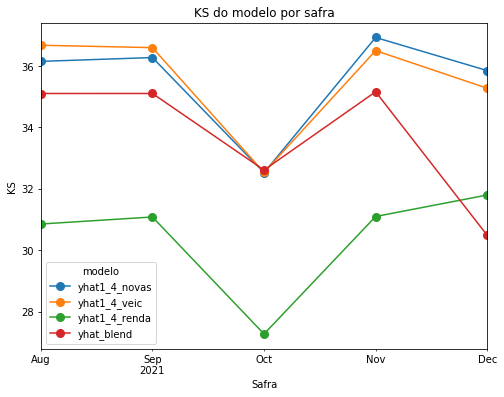

In [0]:
cols_graf = ["yhat1_4_novas"]
vis_cli.ks_por_safra(modelos, safras_ks, col_target=modelo_logistica)

#### Ordenação inad

In [0]:
tab_decis = vis_cli.tabela_qs(cols)
tab_decis

col_0,yhat1_4_novas,yhat1_4_veic,yhat1_4_renda,yhat_blend,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
qs_yhat1_4_novas,,,,,,,,,,,,,
0,6.595995,6.686067,5.826924,1.732142,4.145149,4.560485,5.415088,3.057420,1.250390,1.264113,1.586230,4.021724,1.494293
1,3.699855,3.547426,3.332640,4.621354,2.814412,2.985075,3.123086,2.251806,3.610406,3.821612,3.138491,3.066038,4.301001
2,2.598212,2.632855,2.799141,3.152498,2.172889,2.387195,2.272571,2.063207,2.975697,2.895338,2.244059,2.391350,2.888538
3,1.642070,1.697499,2.050856,2.334927,1.878169,1.965824,1.698100,1.979999,2.598036,2.450878,2.297534,2.005402,2.413913
4,1.475785,1.399570,1.600499,1.662856,1.794747,1.606453,1.568963,2.004439,1.943281,2.182706,1.799632,1.687909,1.981120
5,1.122428,1.136285,1.267928,1.357999,1.428775,1.281348,1.146881,1.445498,1.670426,1.580863,1.530991,1.505525,1.471037
6,0.679000,0.755214,0.789857,0.990785,1.373534,1.362398,1.171345,1.538725,1.452768,1.368997,1.190648,1.270884,1.067126
7,0.595857,0.568142,0.699785,0.685928,1.235868,0.976482,0.954186,1.444320,1.105756,0.909825,NaN,0.927411,0.825287
8,0.173214,0.159357,0.207857,0.318714,0.953043,0.779823,0.656455,1.366139,0.694591,0.711825,NaN,1.009891,0.501964


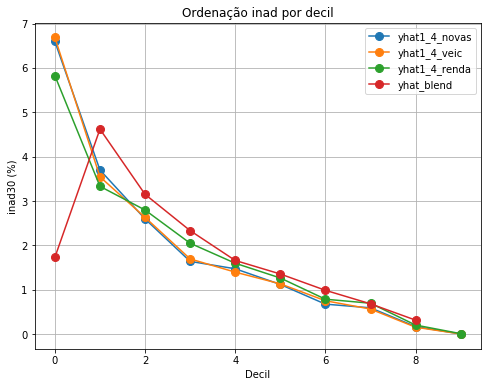

In [0]:
cols_ord = [*modelos, modelo_logistica]
tab_decis[cols_ord].plot(kind="line", title=f"Ordenação inad por decil", figsize=(8,6), marker='.', markersize=16)
plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

## Não clientes

### Avaliação Modelo 1.4 + Novas BVS

In [0]:
"""Considerações Remi: criar um modelo para cada um dos escopos: 
1.score veículos + renda
2.score veículo
3. renda
"""
# Para não clientes, a variável rndrprpnmpfmmlregv1 (Renda) se mostrou estatisticamente insignificante ao demonstar p-valor > 0.1 (valor exato: 0.355) e foi eliminada pelo método de backwarding

X=X3_ncli
y=y_ncli

modelos = []

selected_features_BE=[
 'WoE_score_ajust',
 'WoE_PF_CP_VOL04_PF',
 'P4_BVS',
 'QuodScore_v2',
 'SCORE_HSPN',
 *novas
]

#### Escopo score veículos + renda

In [0]:
X_1 = sm.add_constant(X.loc[:,selected_features_BE])
model = sm.Logit(y,X_1).fit()
X_aplic=['const']+selected_features_BE

base_ncli_pd['const']=1
base_ncli_pd['yhat_novas_ncli'] = model.predict(base_ncli_pd[X_aplic])
base_ncli_pd['yhat1_4_novas_ncli']=(1-base_ncli_pd['yhat_novas_ncli'])*1000
base_ncli_pd['yhat1_4c_novas_ncli']=600-(20/np.log(2))*np.log((1-base_ncli_pd['yhat_novas_ncli'])/(1-(1-base_ncli_pd['yhat_novas_ncli'])))

modelos.append("yhat1_4_novas_ncli")
print(model.summary())

print('KS desenv: ', calc_perf(base_ncli_pd,'yhat1_4_novas_ncli','inad30') )

Optimization terminated successfully.
 Current function value: 0.114054
 Iterations 10
 Logit Regression Results 
==============================================================================
Dep. Variable: inad30 No. Observations: 150969
Model: Logit Df Residuals: 150961
Method: MLE Df Model: 7
Date: Wed, 11 May 2022 Pseudo R-squ.: 0.07655
Time: 18:17:43 Log-Likelihood: -17219.
converged: True LL-Null: -18646.
Covariance Type: nonrobust LLR p-value: 0.000
==========================================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
const 0.1410 0.114 1.239 0.215 -0.082 0.364
WoE_score_ajust -0.5895 0.068 -8.718 0.000 -0.722 -0.457
WoE_PF_CP_VOL04_PF -0.4374 0.053 -8.310 0.000 -0.541 -0.334
P4_BVS -1.397e-08 5.03e-09 -2.775 0.006 -2.38e-08 -4.1e-09
QuodScore_v2 -0.0010 0.000 -7.552 0.000 -0.001 -0.001
SCORE_HSPN 4.227e-08 3.54e-09 11.940 0.000 3.53e-08 4.92e-08
scrcrdpnmveipfctbclfv2 -0.0051 0.000 -26.653 0.000 -0.006 -0.005
rndrprpnmpfmmlregv1 3.485e-06 3.77e-06 0.924 0.355 -3.91e-06 1.09e-05
==========================================================================================
KS desenv: (31.708759366693478, 150969, 2.6820075644668773, 146920, 4049)

In [0]:
lnvar=[]
lbeta=[]
lbetasd=[]

i=0
for nvar in model.params.index[1:len(model.params.index)]:
  i=i+1
  importance=np.abs(model.params[i]*np.std(X[nvar])/np.std(y))
  lnvar=lnvar+[nvar]
  lbeta=lbeta+[model.params[i]]
  lbetasd=lbetasd+[importance]

tab_importance=pd.DataFrame(
  {
    'var': lnvar,
    'Coef': lbeta,
    'Coef_sd':np.round(lbetasd,4)
  }
)
tab_importance['p_imp']=np.round(tab_importance['Coef_sd']*100/tab_importance['Coef_sd'].sum(),3)
tab_importance.sort_values('Coef_sd',ascending=False)

,var,Coef,Coef_sd,p_imp
4,SCORE_HSPN,4.227303e-08,9.0206,60.609
5,scrcrdpnmveipfctbclfv2,-5.130171e-03,2.8898,19.416
0,WoE_score_ajust,-5.895485e-01,0.9931,6.673
1,WoE_PF_CP_VOL04_PF,-4.373817e-01,0.9400,6.316
3,QuodScore_v2,-9.686053e-04,0.7824,5.257
2,P4_BVS,-1.396697e-08,0.1353,0.909
6,rndrprpnmpfmmlregv1,3.484948e-06,0.1221,0.820


#### Escopo veículos

In [0]:
features_escopo = selected_features_BE.copy()
features_escopo.remove("rndrprpnmpfmmlregv1")

X_1 = sm.add_constant(X.loc[:,features_escopo])
model = sm.Logit(y,X_1).fit()
X_aplic=['const']+features_escopo
	
base_ncli_pd['const']=1
base_ncli_pd['yhat_veic_ncli'] = model.predict(base_ncli_pd[X_aplic])
base_ncli_pd['yhat1_4_veic_ncli']=(1-base_ncli_pd['yhat_veic_ncli'])*1000
base_ncli_pd['yhat1_4c_veic_ncli']=600-(20/np.log(2))*np.log((1-base_ncli_pd['yhat_veic_ncli'])/(1-(1-base_ncli_pd['yhat_veic_ncli'])))

modelos.append("yhat1_4_veic_ncli")
print(model.summary())

print('KS desenv: ', calc_perf(base_ncli_pd,'yhat1_4_veic_ncli','inad30') )

Optimization terminated successfully.
 Current function value: 0.114057
 Iterations 10
 Logit Regression Results 
==============================================================================
Dep. Variable: inad30 No. Observations: 150969
Model: Logit Df Residuals: 150962
Method: MLE Df Model: 6
Date: Wed, 11 May 2022 Pseudo R-squ.: 0.07652
Time: 18:17:46 Log-Likelihood: -17219.
converged: True LL-Null: -18646.
Covariance Type: nonrobust LLR p-value: 0.000
==========================================================================================
 coef std err z P>|z| [0.025 0.975]
------------------------------------------------------------------------------------------
const 0.1632 0.111 1.467 0.142 -0.055 0.381
WoE_score_ajust -0.5718 0.065 -8.827 0.000 -0.699 -0.445
WoE_PF_CP_VOL04_PF -0.4173 0.048 -8.715 0.000 -0.511 -0.323
P4_BVS -1.396e-08 5.03e-09 -2.773 0.006 -2.38e-08 -4.09e-09
QuodScore_v2 -0.0010 0.000 -7.624 0.000 -0.001 -0.001
SCORE_HSPN 4.226e-08 3.54e-09 11.937 0.000 3.53e-08 4.92e-08
scrcrdpnmveipfctbclfv2 -0.0051 0.000 -26.637 0.000 -0.006 -0.005
==========================================================================================
KS desenv: (31.649349141677668, 150969, 2.6820075644668773, 146920, 4049)

In [0]:
lnvar=[]
lbeta=[]
lbetasd=[]

i=0
for nvar in model.params.index[1:len(model.params.index)]:
  i=i+1
  importance=np.abs(model.params[i]*np.std(X[nvar])/np.std(y))
  lnvar=lnvar+[nvar]
  lbeta=lbeta+[model.params[i]]
  lbetasd=lbetasd+[importance]

tab_importance=pd.DataFrame(
  {
    'var': lnvar,
    'Coef': lbeta,
    'Coef_sd':np.round(lbetasd,4)
  }
)
tab_importance['p_imp']=np.round(tab_importance['Coef_sd']*100/tab_importance['Coef_sd'].sum(),3)
tab_importance.sort_values('Coef_sd',ascending=False)

,var,Coef,Coef_sd,p_imp
4,SCORE_HSPN,4.225992e-08,9.0178,61.381
5,scrcrdpnmveipfctbclfv2,-5.130879e-03,2.8902,19.673
0,WoE_score_ajust,-5.718011e-01,0.9632,6.556
1,WoE_PF_CP_VOL04_PF,-4.172813e-01,0.8968,6.104
3,QuodScore_v2,-9.759898e-04,0.7883,5.366
2,P4_BVS,-1.395559e-08,0.1352,0.920


#### Escopo renda

In [0]:
features_escopo = selected_features_BE.copy()
features_escopo.remove("scrcrdpnmveipfctbclfv2")

X_1 = sm.add_constant(X.loc[:,features_escopo])
model = sm.Logit(y,X_1).fit()
X_aplic=['const']+features_escopo
	
base_ncli_pd['const']=1
base_ncli_pd['yhat_renda_ncli'] = model.predict(base_ncli_pd[X_aplic])
base_ncli_pd['yhat1_4_renda_ncli']=(1-base_ncli_pd['yhat_renda_ncli'])*1000
base_ncli_pd['yhat1_4c_renda_ncli']=600-(20/np.log(2))*np.log((1-base_ncli_pd['yhat_renda_ncli'])/(1-(1-base_ncli_pd['yhat_renda_ncli'])))

modelos.append("yhat1_4_renda_ncli")
print(model.summary())

print('KS desenv: ', calc_perf(base_ncli_pd,'yhat1_4_renda_ncli','inad30') )

Optimization terminated successfully.
 Current function value: 0.116334
 Iterations 10
 Logit Regression Results 
==============================================================================
Dep. Variable: inad30 No. Observations: 150969
Model: Logit Df Residuals: 150962
Method: MLE Df Model: 6
Date: Wed, 11 May 2022 Pseudo R-squ.: 0.05809
Time: 18:17:49 Log-Likelihood: -17563.
converged: True LL-Null: -18646.
Covariance Type: nonrobust LLR p-value: 0.000
=======================================================================================
 coef std err z P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------
const -1.6485 0.092 -17.974 0.000 -1.828 -1.469
WoE_score_ajust -0.7759 0.067 -11.607 0.000 -0.907 -0.645
WoE_PF_CP_VOL04_PF -0.5315 0.052 -10.130 0.000 -0.634 -0.429
P4_BVS -1.543e-08 5.03e-09 -3.070 0.002 -2.53e-08 -5.58e-09
QuodScore_v2 -0.0023 0.000 -19.919 0.000 -0.002 -0.002
SCORE_HSPN 4.311e-08 3.54e-09 12.179 0.000 3.62e-08 5.01e-08
rndrprpnmpfmmlregv1 1.494e-06 3.86e-06 0.387 0.699 -6.07e-06 9.05e-06
=======================================================================================
KS desenv: (26.517940923389, 150969, 2.6820075644668773, 146920, 4049)

### Validação

In [0]:
#Conversão safra
base_ncli_pd["Safra_main"] = pd.to_datetime(base_ncli_pd["Safra_main"].astype(str), format='%Y%m')

In [0]:
cols = [*modelos, modelo_logistica, *lista_scores]
safras_ks = [safra for safra in pd.DatetimeIndex(base_cli_pd["Safra_main"].unique()) if safra.year < 2022 and safra.month <= 12]

vis_ncli.tabela_ks_por_safra(target, modelos=cols, safras=safras_ks)

modelo,Blend_Novo_1_1_arred,P3_ult_ret,P4_BVS,QuodScore,QuodScore_v2,SCORE_HSPN,SCORE_HVLD,rndrprpnmpfmmlregv1,scrcrdpnmveipfctbclfv2,yhat1_4_novas_ncli,yhat1_4_renda_ncli,yhat1_4_veic_ncli,yhat_blend
Safra,,,,,,,,,,,,,
2021-08-01,16.4022,17.7546,20.2280,16.1027,18.2180,20.0644,16.9749,12.2531,24.1503,26.2568,20.5729,26.1246,24.0511
2021-09-01,16.6297,18.5327,21.7427,15.9145,20.0108,21.5356,18.9365,15.8918,25.8459,27.4848,22.1726,27.7054,25.1830
2021-10-01,17.2721,15.0798,21.1807,17.1182,20.3182,19.1208,17.5648,11.7221,25.0420,27.6679,22.4728,27.7422,25.7289
2021-11-01,19.3539,14.9951,21.2514,17.6625,17.1391,21.2569,17.5713,13.3238,24.6287,25.4436,20.6056,25.4960,25.7772
2021-12-01,15.6414,13.4107,14.6073,1.1893,15.1148,17.1131,15.7267,11.1708,20.2736,22.7869,18.1307,22.8297,19.4497


### Gráficos

#### KS por safra

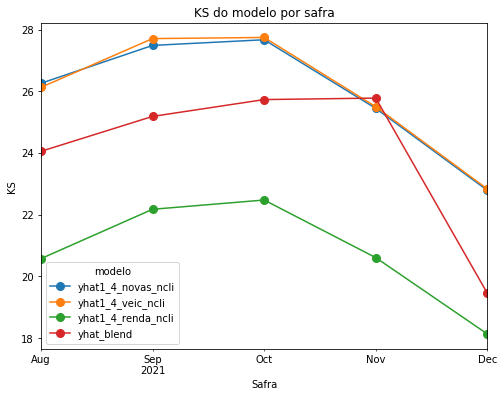

In [0]:
cols_graf = ["yhat_novas_ncli"]
graficos = vis_ncli.ks_por_safra(modelos, safras_ks, col_target=modelo_logistica, agrupar=False)
plt.legend(cols)

#### Ordenação inad

In [0]:
tab_decis = vis_ncli.tabela_qs(cols)
tab_decis

col_0,yhat1_4_novas_ncli,yhat1_4_veic_ncli,yhat1_4_renda_ncli,yhat_blend,P3_ult_ret,P4_BVS,scrcrdpnmveipfctbclfv2,rndrprpnmpfmmlregv1,SCORE_HSPN,SCORE_HVLD,QuodScore,QuodScore_v2,Blend_Novo_1_1_arred
qs_yhat1_4_novas_ncli,,,,,,,,,,,,,
0,7.670398,7.630655,6.531099,7.523246,5.096285,5.948860,6.535134,5.048577,2.220533,1.990477,1.812385,5.521392,1.879612
1,4.630059,4.669802,4.610187,4.956582,3.866421,3.995300,4.398751,3.360244,4.681586,4.420573,4.998291,3.875293,4.443560
2,3.696099,3.689475,3.398026,3.957885,3.429101,3.015584,3.368184,2.903956,3.864640,3.893770,3.548450,3.337041,3.581662
3,2.815129,2.841624,3.013844,3.112272,2.748484,3.226229,2.952079,2.576323,3.404341,3.445529,3.592380,3.026580,3.641568
4,2.656157,2.642909,2.563423,2.881734,2.726803,2.530711,2.614081,2.420374,2.958390,2.982888,3.111501,2.487262,3.205649
5,2.245628,2.212507,2.338368,2.482324,2.532160,2.321931,2.064560,2.190141,2.280344,2.652924,2.350825,2.219712,2.642867
6,1.503610,1.530105,2.066636,2.113271,1.935440,1.840165,1.807269,2.303603,2.096871,2.233344,2.039170,2.005944,2.394375
7,1.026694,1.033318,1.556601,1.667691,1.758370,1.717734,1.244344,1.974416,1.815956,1.731060,1.789318,1.600620,1.784249
8,0.549778,0.543154,0.695502,1.413971,1.453409,1.309091,1.029651,1.977962,1.231609,1.269316,NaN,1.480186,1.188653


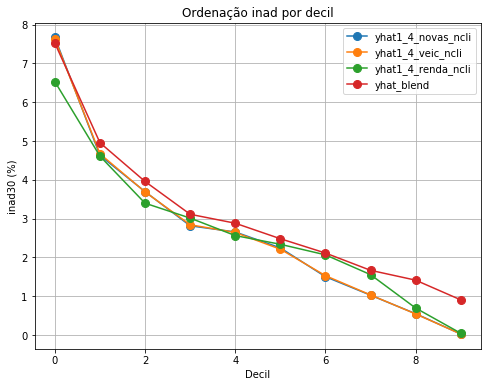

In [0]:
cols_ord = [*modelos, modelo_logistica]
tab_decis[cols_ord].plot(kind="line", title=f"Ordenação inad por decil", figsize=(8,6), marker='.', markersize=16)
plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

# Comparações Quod

## Total

### KS por safra

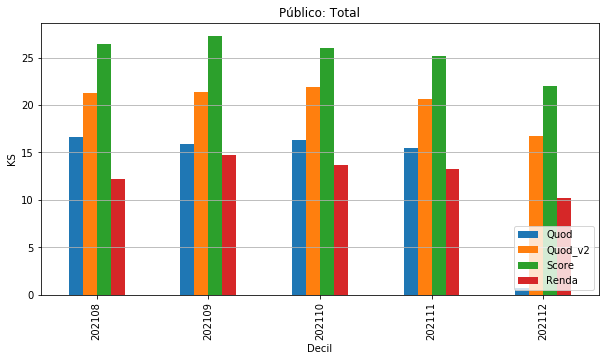

In [0]:
tabela1_KS[['QuodScore','QuodScore_v2','scrcrdpnmveipfctbclfv2','rndrprpnmpfmmlregv1']]\
  .plot.bar(figsize=(10,5),title='Público: Total')

plt.ylabel('KS')
plt.xlabel('Decil')
plt.grid(True,axis='y')
plt.legend(['Quod','Quod_v2','Score','Renda'],loc='lower right',)

### Ordenação inad

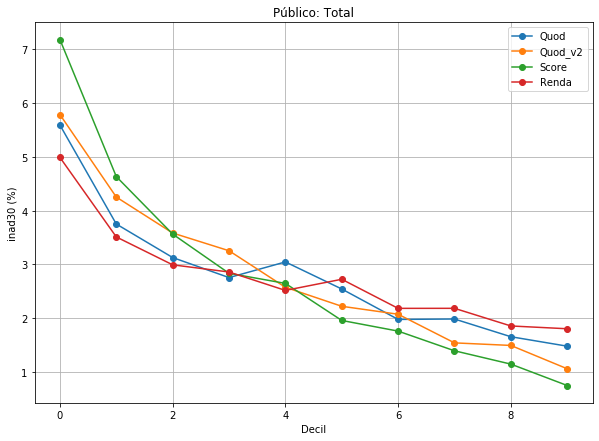

In [0]:
tabela1_inad['QuodScore'].plot.line(marker='o',label='Quod',figsize=(10,7))
tabela1_inad['QuodScore_v2'].plot.line(marker='o',label='Quod_v2',figsize=(10,7))
tabela1_inad['scrcrdpnmveipfctbclfv2'].plot.line(marker='o',label='Score',figsize=(10,7))
tabela1_inad['rndrprpnmpfmmlregv1'].plot.line(marker='o',label='Renda',figsize=(10,7),
                                             title='Público: Total')

plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

## Clientes

#### KS por safra

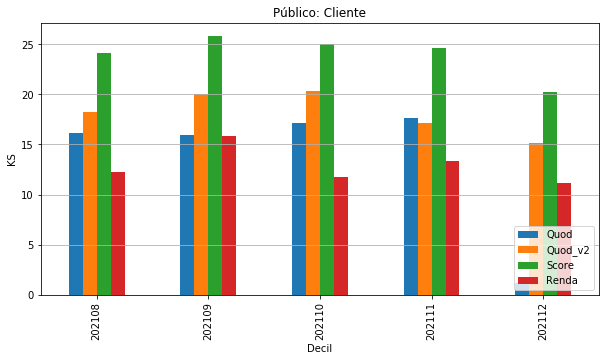

In [0]:
tabela2_KS[['QuodScore','QuodScore_v2','scrcrdpnmveipfctbclfv2','rndrprpnmpfmmlregv1']]\
  .plot.bar(figsize=(10,5),title='Público: Cliente')

plt.ylabel('KS')
plt.xlabel('Decil')
plt.grid(True,axis='y')
plt.legend(['Quod','Quod_v2','Score','Renda'],loc='lower right',)

### Ordenação inad

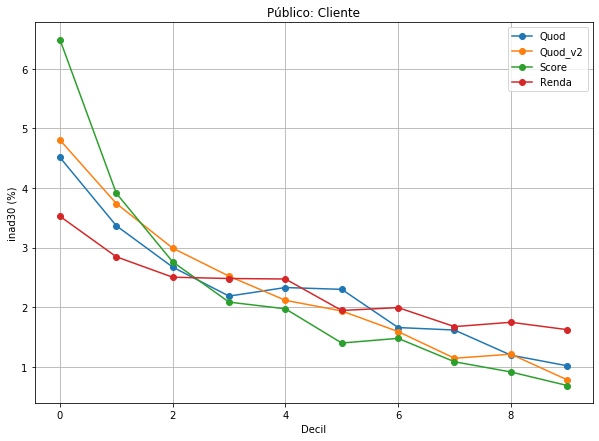

In [0]:
tabela3_inad['QuodScore'].plot.line(marker='o',label='Quod',figsize=(10,7))
tabela3_inad['QuodScore_v2'].plot.line(marker='o',label='Quod_v2',figsize=(10,7))
tabela3_inad['scrcrdpnmveipfctbclfv2'].plot.line(marker='o',label='Score',figsize=(10,7))
tabela3_inad['rndrprpnmpfmmlregv1'].plot.line(marker='o',label='Renda',figsize=(10,7),
                                             title='Público: Cliente')
plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

## Não clientes

#### KS por safra

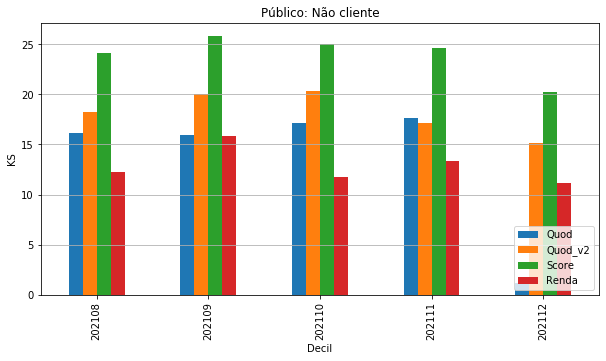

In [0]:
tabela2_KS[['QuodScore','QuodScore_v2','scrcrdpnmveipfctbclfv2','rndrprpnmpfmmlregv1']]\
  .plot.bar(figsize=(10,5),title='Público: Não cliente')

plt.ylabel('KS')
plt.xlabel('Decil')
plt.grid(True,axis='y')
plt.legend(['Quod','Quod_v2','Score','Renda'],loc='lower right',)

### Ordenação inad

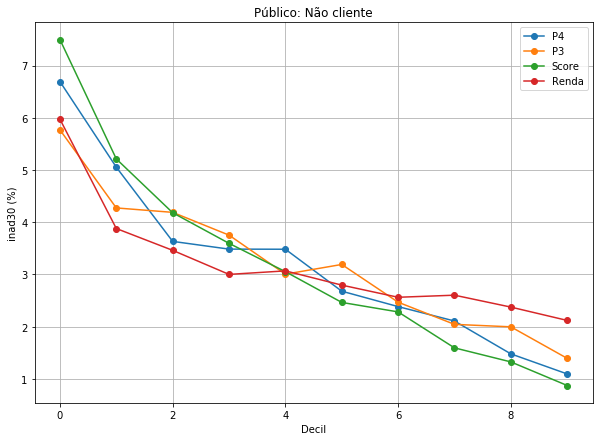

In [0]:
tabela2_inad['P4_BVS'].plot.line(marker='o',label='P4',figsize=(10,7))
tabela2_inad['P3_ult_ret'].plot.line(marker='o',label='P3',figsize=(10,7))
tabela2_inad['scrcrdpnmveipfctbclfv2'].plot.line(marker='o',label='Score',figsize=(10,7))
tabela2_inad['rndrprpnmpfmmlregv1'].plot.line(marker='o',label='Renda',figsize=(10,7),
                                             title='Público: Não cliente')

plt.ylabel('inad30 (%)')
plt.xlabel('Decil')
plt.grid(True)
plt.legend()

# Rascunhos